In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#seaborn 'colorblind' palette
c1,c3,c2,_,_,_,_ = clrs = mpl.rcParams['axes.color_cycle'] = \
[(0.0, 0.4470588235294118, 0.6980392156862745),
 (0.0, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.4745098039215686, 0.6549019607843137),
 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 array((106,65,47))/255.] #muted brown, not originally part of 'colorblind'

In [3]:
import cPickle as pickle
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter
import os.path as osp
import cosmoslik as K
from itertools import chain
import camb

# Begin stuff for the params vs. $\ell_{\rm max}$ figure

Load the results on the real data:

In [4]:
r=dict(pickle.load(open("dat/result_real")))
# for x in r.values():
#     x['clTT']=x['clTT'][:2509]
#     x['clTT_decal']=x['clTT']/x['calPlanck']**2
#     x['cosmo.ommh2']+=0.06/94.

Load the sims:

In [5]:
sims=pickle.load(open('dat/ch/ch.pkl'))

In [6]:
allslices=set((l1,l2) for (l1,l2) in set(chain(*[s.keys() for s in sims.values()])) if l1!=30)
goodsims = {k:s for k,s in sims.items() if all([x in s for x in allslices])}
ps = [k for k in goodsims.values()[0].values()[0] if k.startswith('cosmo') and '8' not in k]
# shifts = {lslice:K.chains.Chain({k:array([s[lslice][k] - s[(2,2509)][k] for s in goodsims.values()]) for k in ps})
#           for lslice in allslices}
# shifts = {lslice:K.chains.Chain({k:array([s[lslice][k] for s in goodsims.values()]) for k in ps})
#           for lslice in allslices}
shifts = {lslice:K.chains.Chain({k:array([s[(2,lslice)][k] - s[(lslice,2509)][k] for s in goodsims.values()]) for k in ps})
          for lslice in range(650,1200,50)}

Silvia's stuff for comparing `plik` to `plik_lite`

In [7]:
def read_minimum(f):
    return {k:float(v) for k,v in [array(l.split())[[2,1]] for l in open(f).readlines()[3:-5] if l.strip()]}

lmaxs=[999, 1197, 1296, 1404, 1503, 1605, 1809, 1996, 2310]

silviar={}
silviar.update({(2,lmax):read_minimum('dat/lmax_minima/base_FIX_TTFGokCAMB_PCAL_PSZ_plik_dx11dr2_HM_v18_LMAX%i_TT_lowl_tauprior0702.minimum'%lmax) for lmax in lmaxs}) 
silviar.update({(30,lmax):read_minimum('dat/lmax_minima/base_FIX_TTFGokCAMB_PCAL_PSZ_plik_dx11dr2_HM_v18_LMAX%i_TT_tauprior0702.minimum'%lmax) for lmax in lmaxs})

silviarff={}
silviarff.update({(2,lmax):read_minimum('dat/lmax_minima/base_PCAL_PSZ_plik_dx11dr2_HM_v18_LMAX%i_TT_lowl_tauprior0702.minimum'%lmax) for lmax in lmaxs})
silviarff.update({(30,lmax):read_minimum('dat/lmax_minima/base_PCAL_PSZ_plik_dx11dr2_HM_v18_LMAX%i_TT_tauprior0702.minimum'%lmax) for lmax in lmaxs})

In [8]:
name_mapping = {'cosmo.ommh2':'omegamh2',
                'cosmo.ombh2':'omegabh2',
                's8omm1/4':'s8omegamp25',
                'cosmo.omch2':'omegach2',
                'cosmo.H0':'H0',
                'cosmo.logA':'logA',
                'cosmo.theta':'theta',
                'cosmo.ns':'ns',
                'cosmo.tau':'tau'}

`plik_lite` chains:

In [9]:
cme={k:K.utils.load_chain("dat/chains/test_chain_%i_%i.chain"%k).burnin(3000).join()
     for k in [(2,2510),(2,2000),(2,1100),(800,2510),(1000,2510),(1200,2510)]}
for c in cme.values():
    c['cosmo.ommh2']=c['cosmo.ombh2']+c['cosmo.omch2']+0.06/94.
    
# cali=K.chains.load_chain("chains/2tauP2500/test").burnin(5000).join()

### Make the figure

In [10]:
params = [('cosmo.H0',r'$H_0$'),
          ('cosmo.ommh2',r'$\omega_m$'),          
          ('cosmo.ombh2',r'$\omega_b$'),
          
          ('cosmo.logA',r'$\log A$'),
          ('cosmo.ns',r'$n_s$'),
          ('cosmo.tau',r'$\tau$'),
        
          ('cosmo.theta',r'$\theta$'),
#           ('s8omm1/4',r'$\sigma_8 \Omega_m^{0.25}$'),
          ('cosmo.clamp',r'$A_s e^{-2\tau}$'),
          
#           ('calPlanck','$y_p$'),
#           ('highl_chi2',r'$\chi^2$')
         ]


def mkplot(low=True,mid=True,high=True,
           smid_fgfree=False,slow_fgfree=False,
           smid_fgfix=False,slow_fgfix=False,
           chains=False,bands=[1,2],alpha=0.1):
    
    fig=figure()
    fig.set_size_inches(2*6,5*6/2)
    fig.subplots_adjust(hspace=0.1,wspace=0.3)


    for i,(n,pn) in enumerate(params):
        ax=subplot(5,2,i+1)

        if high:
            ells=range(100,1200,50); #ells.remove(1100)
            plot(ells,[r[(lsplit,2509)][n] for lsplit in ells],'.-',c=c2,lw=1.5,markersize=6,
                 label=r'$(\ell_{\rm split},2500)$')                  
                
        if low:
            ells=range(700,2500,50); #ells.remove(1100)
            plot(ells,[r[(2,lsplit)][n] for lsplit in ells],'.-',c=c1,lw=1.5,markersize=6, 
                 label=r'$(2,\ell_{\rm split})$')          
            
        if mid:
            ells=range(700,2500,50); #ells.remove(1100)
            plot(ells,[r[(30,lsplit)][n] for lsplit in ells],'.-',c=c3,lw=1.5,markersize=6,
                 label=r'$(30,\ell_{\rm split})$')


        np=name_mapping.get(n,n).replace('*','')
        if silviar and np in silviar.values()[0]:
            if slow_fgfree:
                plot(lmaxs,[silviarff[(2,lsplit)][np] for lsplit in lmaxs],'r.-',
                     label=r'${\rm Plik \,} (2,\ell_{\rm split}) \, \rm fgs \, free$')                            
                
            if smid_fgfree:
                plot(lmaxs,[silviarff[(30,lsplit)][np] for lsplit in lmaxs],'r--',
                     label=r'${\rm Plik \,} (30,\ell_{\rm split}) \, \rm fgs \, free$')                            

            if slow_fgfix:
                plot(lmaxs,[silviar[(2,lsplit)][np] for lsplit in lmaxs],'g.-',
                     label=r'${\rm Plik \,} (2,\ell_{\rm split}) \, \rm fgs \, fixed$')                            
                
            if smid_fgfix:
                plot(lmaxs,[silviar[(30,lsplit)][np] for lsplit in lmaxs],'g--',
                     label=r'${\rm Plik \,} (30,\ell_{\rm split}) \, \rm fgs \, fixed$')                            

        lims=ax.get_ylim()        
                
        if chains:
            if n in cme.values()[0]:
                for l in [1100,2000,2510]:
                    errorbar([l],[cme[2,l].mean(n)],[cme[2,l].std(n)],c=c1,marker='.',ls='',label='')
                
                for l in [800,1000]:
                    errorbar([l],[cme[l,2510].mean(n)],[cme[l,2510].std(n)],c=c2,marker='.',ls='',label='')                
                
            np=name_mapping.get(n,n)
            if np in cali:
                errorbar([2520],[cali.mean(np)],[cali.std(np)],c='m',marker='.',ls='')

        ells=range(650,1200,50)
        for y in bands:
            fill_between(ells,*([(r[(2,lmin)][n]+r[(lmin,2509)][n])/2 - y*x*shifts[lmin].std(n) for lmin in ells] for x in [-1,1]),
                         color='gray',edgecolor='',zorder=-1,alpha=alpha)
                
                
#         if high:
#             ells=range(100,1200,50)
#             for y in bands:
#                 fill_between(ells,*([r[(lmin,2509)][n] - y*x*shifts[lmin,2509].std(n) for lmin in ells] for x in [-1,1]),
#                              color=c2,edgecolor='',zorder=-1,alpha=alpha)

#                 for x in [-y,y]:
#                     plot(ells,[r[(lmin,2509)][n] - x*shifts[lmin,2509].std(n) for lmin in ells],c=c2,ls='--',zorder=-1)

#         if low:
#             ells=range(700,2500,50)
#             for y in bands:
#                 fill_between(ells,*([r[(2,lmax)][n] - y*x*shifts[2,lmax].std(n) for lmax in ells] for x in [-1,1]),
#                      color=c1,edgecolor='',zorder=-1,alpha=alpha)

#                 for x in [-y,y]:
#                     plot(ells,[r[(2,lmax)][n] - x*shifts[2,lmax].std(n) for lmax in ells],c=c1,ls='--',zorder=-1)

                
        if n=='highl_chi2':
            ells=range(700,2500,50); plot(ells,[r[(30,lsplit)]['highl_dof']-6 for lsplit in ells],'-.',c=c1,lw=1.5,markersize=6)
            ells=range(100,1700,50); plot(ells,[r[(lsplit,2510)]['highl_dof']-6 for lsplit in ells],'-.',c=c2,lw=1.5,markersize=6)

        ax.set_ylim(*lims)
        ax.set_xlim(0,2600)

        if 1<i<8:
            ax.set_xticklabels([])
        else:
            if i>8: xlabel(r'$\ell_{\rm split}$',size=20)
            if i<2: ax.tick_params(labelbottom='off',labeltop='on')
        ylabel(pn,size=20)  

        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(4))    
        ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

        if i==1: legend(ncol=3, loc='lower center', bbox_to_anchor=(-0.15, 1.1),prop={'size':20})

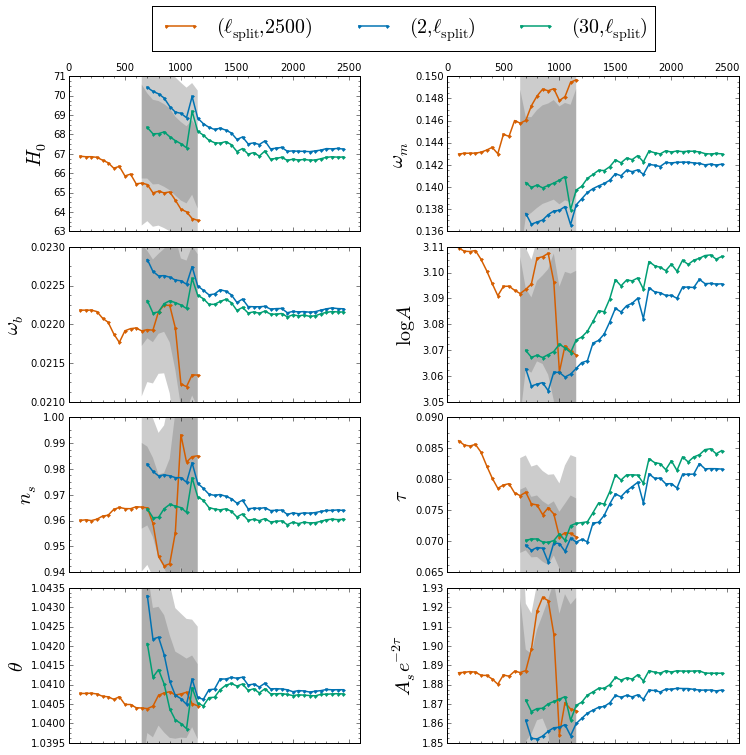

In [11]:
mkplot(bands=[1,2],alpha=0.4)
# savefig('/plots/params_vs_lsplit.pdf',bbox_inches='tight')

The "debug" version comparing to Silvia's runs

In [ ]:
mkplot(slow_fgfree=True, slow_fgfix=True, chains=True)
savefig('plots/params_vs_lsplit_debug.pdf',bbox_inches='tight')

# Begin stuff for the "bestfit_shifts_components" figure

Compute derivatives:

In [130]:
def getcl(p,k):
    return camb.get_results(
        camb.set_params(
            lmax=5000,
            kmax=10000,
            ns=p['cosmo.ns'],
            As=exp(p['cosmo.logA'])*1e-10,
            ombh2=p['cosmo.ombh2'],
            omch2=p['cosmo.omch2'],
            tau=p['cosmo.tau'],
            H0=None,
            cosmomc_theta=p['cosmo.theta']/100
        )).get_cmb_power_spectra()[k][:,0]*(2.7255e6)**2

def getdCl(params0,pdps,k,fac=1e3):
    params1=params0.copy()
    for p,dp in pdps: params1[p]+=dp/fac
    cl1,cl0 = (getcl(ps,k) for ps in [params1,params0])
    return (cl1-cl0)/(pdps[0][1]/fac)
    
def getdCls(lmin,lmax,k='lensed_scalar'):    
    p0=r[lmin,lmax]
    dCls={}
    dCls['cosmo.theta']=getdCl(p0,[('cosmo.theta',0.0104)],k=k)
    dCls['cosmo.ommh2']=getdCl(p0,[('cosmo.omch2',0.12)],k=k)
    dCls['cosmo.ombh2']=getdCl(p0,[('cosmo.ombh2',0.02),('cosmo.omch2',-0.02)],k=k)
    dCls['cosmo.ns']   =getdCl(p0,[('cosmo.ns',0.96)],k=k)
    dCls['cosmo.tau']  =getdCl(p0,[('cosmo.tau',0.09),('cosmo.logA',2*0.09)],fac=1e2,k=k)
    dCls['cosmo.clamp']=getdCl(p0,[('cosmo.logA',3)],k=k)/p0['cosmo.clamp']
    return dCls

In [106]:
dCls=getdCls(2,800)

In [131]:
dCls_scalar=getdCls(2,800,'unlensed_scalar')

KeyboardInterrupt: 

Load `plik_lite` data

In [8]:
in_lslice=slice(30,2509)
import struct
todl=arange(2509)*(arange(2509)+1)/2/pi

def load_cl(filename):
    return hstack([zeros(in_lslice.start),loadtxt(filename)[:,1]])*todl

def load_cov(filename):
    f=open(filename).read()
    cmbcov=zeros((2509,2509))
    start=in_lslice.start
    nl=in_lslice.stop - in_lslice.start
    cmbcov[start:,start:]=array(struct.unpack('d'*(len(f)/8-1),f[4:-4])).reshape((nl,nl))
    for i in arange(cmbcov.shape[0]):
        for j in arange(i):
            cmbcov[j,i]=cmbcov[i,j]
    return (cmbcov*todl).T*todl

pkcl = load_cl('dat/cmbcls/cl_cmb_plik_bin1_v18.dat')
pkcv = load_cov('dat/cmbcls/c_matrix_plik_bin1_v18.dat')

In [9]:
import mspec as M
import pyfits

# lims=hstack([arange(30,2509,99)])
lims=array([30]+range(100,2500,50)+[2509])
bin=M.get_bin_func('q',q=M.lims_to_q(zip(lims,lims[1:]-1)))

lowl=pyfits.open('dat/COM_PowerSpect_CMB_R2.02.fits')[1].data

Various stuff for plotting:

In [10]:
lmap=vectorize(lambda l, lpiv=100., lstretch=100.: lpiv+lstretch*log(l/lpiv) if l<lpiv else l)

In [11]:
name_mapping={'cosmo.theta':'100theta',
              'cosmo.ommh2':'omegamh2*',
              'cosmo.ombh2':'ombh2',
              'cosmo.ns':'scalar_spectral_index(1)',
              'cosmo.clamp':'clamp*',
              'cosmo.tau':'re_optical_depth'}

In [12]:
def boxerrs(lmins,lmaxs,ys,errs,lrange,dl=6,ax=None,**kwargs):
    if ax is None: ax=gca()
    for (lmin,lmax,y,err) in zip(lmins,lmaxs,ys,errs):
        ax.fill_between(lmap((lmin+dl,lmax-dl)),[y-err]*2,[y+err]*2,
                        facecolor='darkgray' if lmax<=lrange[1] else 'lightgray',edgecolor='dimgray',
                        alpha=1 if lmax<=lrange[1] else 0.7, lw=0.5,**kwargs)

In [13]:
color_map = [
             ('cosmo.clamp',clrs[2],r'$A_s e^{-2\tau}$'),
             ('cosmo.ns',clrs[6],'$n_s$'),    
             ('cosmo.tau',clrs[5],r'$\tau$'),
             ('cosmo.ombh2',clrs[3],r'$\omega_b$'),
             ('cosmo.theta',clrs[0],r'$\theta$'),
             ('cosmo.ommh2',clrs[1],r'$\omega_m$'),        
             ('cosmo.ampns',clrs[2],r'$A_s e^{-2\tau},n_s$')
            ]

The function which makes one panel of the plot:

In [498]:
def mkpanel((lmin,lmax),(lmin_fid,lmax_fid),lims,
            notheta=False,ampns=False,linsum=False,
            lswitch=500,
            doleg=False,xlbl=True,ylbl=True,dodat=True,docomps=True,
            fid=None,arrows=False,doscalar=False,domode=False,color_map=color_map,
            fac={},domodel=True,
            axs=None):
    
    if axs is not None:
        ax1,ax2=axs
    else:
        ax1=gca()
        ax2=ax1.twinx()
    
    
    def plot(x,y,*args,**kwargs):
        ax1.plot(x[:bsplit],y[:bsplit],*args,**kwargs)
        ax2.plot(x[bsplit:],y[bsplit:],*args,**kwargs)

    bin=M.get_bin_func('q',q=M.lims_to_q(zip(lims,lims[1:]-1)))
    
    bsplit=bin(arange(lswitch)).size

    
    r1=r[lmin,lmax]
    r2=r[lmin_fid,lmax_fid]
    fid=r2['clTT'][:2509]
    
    y=lowl['D_ELL'].mean() - (fid*todl)[2:30].mean(); err=1/sqrt(sum(1/lowl['ERRUP']**2))        
    dfac=1#hstack([[err],sqrt(diag(bin(pkcv)))[1:]])

    dClsdp={k:dCls[k][:2509]*(r1[k] - r2[k])*fac.get(k,1) for k in dCls}
    dClsdp_scalar={k:dCls_scalar[k][:2509]*(r1[k] - r2[k])*fac.get(k,1) for k in dCls}
    
    if ampns:
        dClsdp['cosmo.ampns']=dClsdp.pop('cosmo.clamp')+dClsdp.pop('cosmo.ns')
        

    if notheta:
        fid=hstack([zeros(2),r2['clTT'][2:2509] + dClsdp.pop('cosmo.theta')[2:2509]/todl[2:]])
        dClsdp_scalar.pop('cosmo.theta')

    if domode:
        dClsdp['cosmo.ampns']=sum(dClsdp.pop(x) for x in dClsdp.keys() if 'tau' not in x and 'theta' not in x)
        
    if docomps:
        for k,c,l in color_map:
            if k in dClsdp:
                plot(lmap(bin(arange(2509))),bin(dClsdp[k])/dfac,lw=2,label=l,c=c)
                if doscalar: plot(lmap(bin(arange(2509))),bin(dClsdp_scalar[k])/dfac,lw=2,label=l,c=c,ls='--')


    if linsum:
        plot(lmap(bin(arange(2509))),bin(sum(dClsdp.values(),axis=0))/dfac,'k',lw=2,ls='--',label=r'$\rm linear$')
        
#         dClsdp.pop('cosmo.ombh2')
#         plot(lmap(bin(arange(2509))),bin(sum(dClsdp.values(),axis=0))/dfac,'k',lw=2,ls='--',label=r'$\rm linear$')
        
        if doscalar:
            plot(lmap(bin(arange(2509))),bin(sum(dClsdp_scalar.values(),axis=0))/dfac,'k',lw=2,ls='--')
            
            bslice=bin(slice(lmin,lmax))
            dx_fid=bin(pkcl-fid*todl)[bslice]                        
            dx=bin(pkcl-fid*todl-sum(dClsdp.values(),axis=0))[bslice]            
            dx_scalar=bin(pkcl-fid*todl-sum(dClsdp_scalar.values(),axis=0))[bslice]
            print bslice.stop - bslice.start
            print dot(dx_fid,dot(inv(bin(pkcv)[bslice,bslice]),dx_fid))            
            print dot(dx,dot(inv(bin(pkcv)[bslice,bslice]),dx))
            print dot(dx_scalar,dot(inv(bin(pkcv)[bslice,bslice]),dx_scalar))

            
        
        
    if domodel: plot(lmap(bin(arange(2509))),bin(((r1['clTT'][:2509] - fid)*todl))/dfac,'k',lw=2,label=r'$\rm total$')

    if dodat:
        ax1.fill_between(lmap([2,30]),[y-err]*2,[y+err]*2,facecolor='darkgray' if lmin==2 else 'lightgray',
                         alpha=1 if lmin==2 else 0.7,edgecolor='dimgray',lw=0.5)
        boxerrs(bin.lmins[1:bsplit],bin.lmaxs[1:bsplit],bin(pkcl-fid*todl)[1:bsplit],sqrt(diag(bin(pkcv)))[1:bsplit], (2,lmax),ax=ax1)
        boxerrs(bin.lmins[bsplit:],bin.lmaxs[bsplit:],bin(pkcl-fid*todl)[bsplit:],sqrt(diag(bin(pkcv)))[bsplit:], (2,lmax),ax=ax2)

    plot([lswitch]*2,[-200,200],'k:')

    plot(lmap([1,2509]),[0]*2,'k',zorder=100)


    if doleg: legend(loc='lower center', bbox_to_anchor=(1, 1.1),ncol=3,prop=dict(size=18))
    ticks=[2,100]+range(500,2500,500)
    ax=gca()
    ax.set_xticks(lmap(ticks))
    ax.set_xticks(lmap(range(10,100,10)+range(100,2500,100)),minor=True);

    ax.set_xticklabels(ticks)
    if xlbl: ax1.set_xlabel(r'${\rm multipole \, moment,}\,\ell$',size=18)

    if ylbl: ax1.set_ylabel(r'$\Delta D_\ell\,[\rm \mu K^2]$',size=18)        

    ax.yaxis.set_minor_locator(AutoMinorLocator(5))    

    ax1.set_ylim(-120,120)
    ax2.set_ylim(-37,37)
    
    xlim(lmap(1),lmap(2509))

    if arrows:
        for p in [220,537.5,810.8,1120.9,1444.2,1776,2081,2395]:
            ax.arrow(p, 34, 0, -4, head_width=50, head_length=2, fc='k', ec='k')

    return ax1,ax2

In [15]:
lims=array([2,30]+range(100,2500,50)+[2500])
# lims=array([2,30]+range(100,850,50)+[2500])
# lims=array([2,30]+range(100,850,50)+[1000,2500])
bin=M.get_bin_func('q',q=M.lims_to_q(zip(lims,lims[1:]-1)))

Get the (surprising) $\chi^2$ between the two cases:

33.0288748929 34
36.3935264754 34


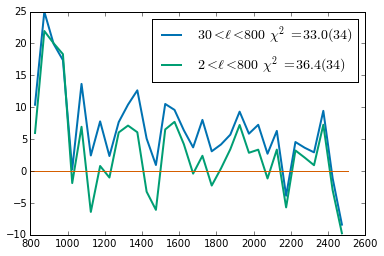

In [16]:
bslice=bin(slice(800,2500))
dx=bin(pkcl-r[30,800]['clTT'][:2509]*todl)[bslice]
print dot(dx,dot(inv(bin(pkcv)[bslice,bslice]),dx)), dx.size
plot(bin(arange(2509))[bslice],dx,lw=2)

bslice=bin(slice(800,2500))
dx=bin(pkcl-r[2,800]['clTT'][:2509]*todl)[bslice]
print dot(dx,dot(inv(bin(pkcv)[bslice,bslice]),dx)), dx.size
plot(bin(arange(2509))[bslice],dx,lw=2)

legend([r'$30<\ell<800\,\chi^2=33.0(34)$',
        r'$2<\ell<800\,\chi^2=36.4(34)$',],fontsize=14)

plot([800,2509],[0]*2)

Make the beast:

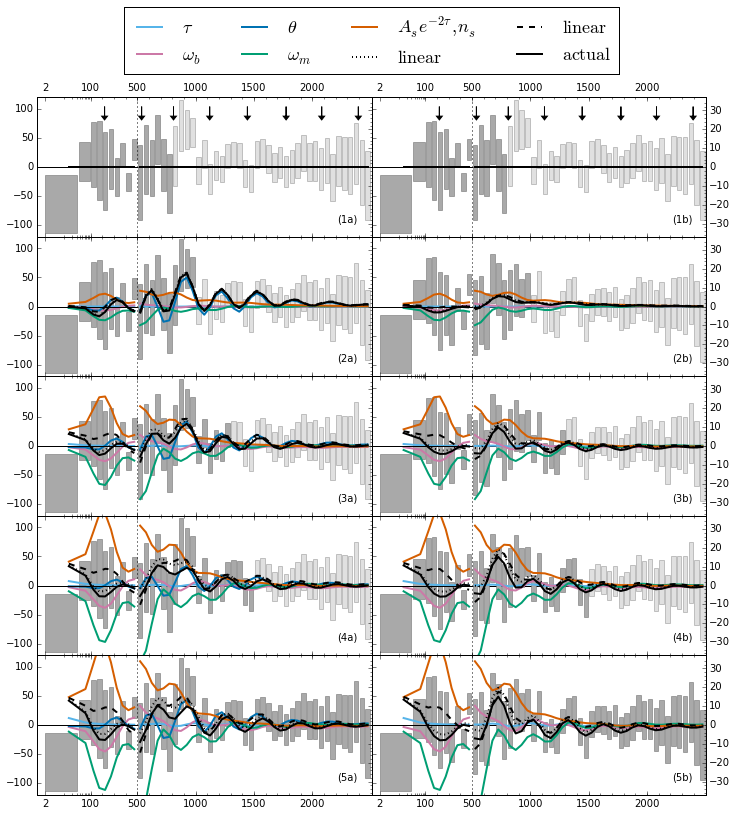

In [31]:
fig=figure()
fig.set_size_inches(2*6,5*6/2.4)
fig.subplots_adjust(hspace=0,wspace=0)

lims=array([2,30]+range(100,2500,50)+[2500])
# lims=array([2,30]+range(100,1000,50)+[2500])
# lims=array([2,30]+range(100,850,50)+[1000,2500])
bin=M.get_bin_func('q',q=M.lims_to_q(zip(lims,lims[1:]-1)))

# r2=r[2,800]
# fid=r2['clTT'][:2509]
todl=arange(2509)*(arange(2509)+1)/2/pi

for j in [0,1]:
    for i,lmax in enumerate([800,1000,1300,1500,2509]):
        
        ax=subplot(5,2,2*i+j+1)

        mkpanel((2,lmax),(2,800),lims,ampns=True,lswitch=500,linsum=True,
                notheta=(j==1),doleg=(i==0 and j==0),xlbl=(i==4),ylbl=(j==0),arrows=(i==0),domode=(j==10))

        if i==0: ax.tick_params(labelbottom='off',labeltop='on')
        elif i!=4: ax.set_xticklabels([])
        if j!=0: ax.set_yticklabels([])
        text(0.9,0.1,'(%i%s)'%(i+1,'ab'[j]),transform=ax.transAxes)

        
# savefig('/plots/bestfit_shift_components_scaled_twocol_nolowl.pdf',bbox_inches='tight')

In [114]:
dclamp=r[2,2509]['cosmo.clamp']-r[2,800]['cosmo.clamp']
dns=r[2,2509]['cosmo.ns']-r[2,800]['cosmo.ns']
dommh2=r[2,2509]['cosmo.ommh2']-r[2,800]['cosmo.ommh2']
dombh2=r[2,2509]['cosmo.ombh2']-r[2,800]['cosmo.ombh2']

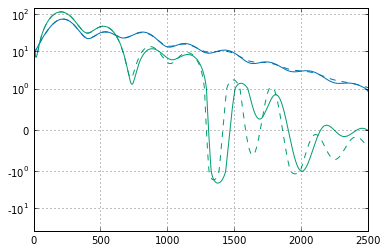

In [170]:
plot(dCls['cosmo.clamp']*dclamp+0*dCls['cosmo.ns']*dns,c=clrs[0],ls='--')
plot(dCls_scalar['cosmo.clamp']*dclamp+0*dCls_scalar['cosmo.ns']*dns,c=clrs[0],ls='-')

plot(-dCls['cosmo.ommh2']*dommh2,c=clrs[1],ls='--')
plot(-dCls_scalar['cosmo.ommh2']*dommh2,c=clrs[1],ls='-')


# plot(-dCls['cosmo.ombh2']*dombh2,c=clrs[2],ls='--')
# plot(-dCls_scalar['cosmo.ombh2']*dombh2,c=clrs[2],ls='-')

ylim(-40,150)

grid(b=True, which='major')
xlim(0,2500)
yscale('symlog',linthreshy=1)

In [257]:
camb.set_params(H0=None,cosmomc_theta=r[2,800]['cosmo.theta']/100)

TypeError: 'CAMBparams' object has no attribute '__getitem__'

In [262]:
camb.get_background(camb.set_params(H0=None,cosmomc_theta=r[2,800]['cosmo.theta']/100)).get_derived_params()

{'DAstar': 13.882069384547552,
 'age': 13.795728934047702,
 'kd': 0.14012219311468818,
 'keq': 0.010356887957900478,
 'rdrag': 147.50655669998957,
 'rstar': 144.71700776195954,
 'thetad': 0.1615060278075953,
 'thetaeq': 0.8148794066024199,
 'thetarseq': 0.45051503836026496,
 'thetastar': 1.0424743152706566,
 'zdrag': 1059.0553283691406,
 'zeq': 3393.360659678265,
 'zstar': 1090.3549194335938}

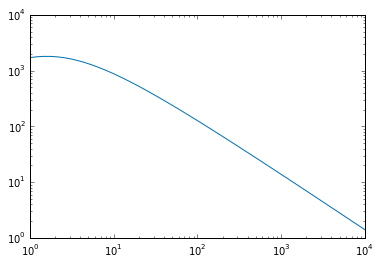

In [267]:
z=logspace(0,4); loglog(z,b.angular_diameter_distance(z))

In [263]:
camb.get_background(camb.set_params(H0=None,cosmomc_theta=r[2,1000]['cosmo.theta']/100)).get_derived_params()

{'DAstar': 13.903229828643793,
 'age': 13.843213832290095,
 'kd': 0.14012219366886194,
 'keq': 0.01035688795789716,
 'rdrag': 147.50655670039973,
 'rstar': 144.71700776232692,
 'thetad': 0.16126021815171987,
 'thetaeq': 0.8136391760703494,
 'thetarseq': 0.4498293632760687,
 'thetastar': 1.0408876897379427,
 'zdrag': 1059.0553283691406,
 'zeq': 3393.3606596782656,
 'zstar': 1090.3549194335938}

In [261]:
b.get_derived_params()

{'DAstar': 13.882069384547552,
 'age': 13.795728934047702,
 'kd': 0.14012219311468818,
 'keq': 0.010356887957900478,
 'rdrag': 147.50655669998957,
 'rstar': 144.71700776195954,
 'thetad': 0.1615060278075953,
 'thetaeq': 0.8148794066024199,
 'thetarseq': 0.45051503836026496,
 'thetastar': 1.0424743152706566,
 'zdrag': 1059.0553283691406,
 'zeq': 3393.360659678265,
 'zstar': 1090.3549194335938}

In [ ]:
(camb.set_params(H0=None,cosmomc_theta=r[2,800]['cosmo.theta']/100).H0 -
 camb.set_params(H0=None,cosmomc_theta=r[2,1000]['cosmo.theta']/100).H0)

In [319]:
(camb.set_params(H0=None,cosmomc_theta=r[2,800]['cosmo.theta']/100).H0 -
 camb.set_params(H0=None,cosmomc_theta=r[2,1000]['cosmo.theta']/100).H0)

0.5294029105474323

In [160]:
(camb.set_params(H0=None,cosmomc_theta=r[30,800]['cosmo.theta']/100).H0 -
 camb.set_params(H0=None,cosmomc_theta=r[30,1000]['cosmo.theta']/100).H0)

0.46370172091403106

In [ ]:
camb.CAMBparams.set_cosmology()

In [324]:
(camb.set_params(H0=None,cosmomc_theta=r[2,1000]['cosmo.theta']/100, ombh2=r[2,1000]['cosmo.ombh2'],omch2=r[2,1000]['cosmo.omch2']).H0 -
 camb.set_params(H0=None,cosmomc_theta=r[2,1000]['cosmo.theta']/100, ombh2=r[2,1000]['cosmo.ombh2'],omch2=r[2,2509]['cosmo.omch2']).H0)

1.546227356714951

In [162]:
(camb.set_params(H0=None,cosmomc_theta=r[2,800]['cosmo.theta']/100, ombh2=r[2,800]['cosmo.ombh2'],omch2=r[2,800]['cosmo.omch2']).H0 -
 camb.set_params(H0=None,cosmomc_theta=r[2,800]['cosmo.theta']/100, ombh2=r[2,800]['cosmo.ombh2'],omch2=r[2,1000]['cosmo.omch2']).H0)

0.41659748961230036

In [154]:
r[2,800]['cosmo.H0'] - r[2,1000]['cosmo.H0']

1.0050702360511679

In [155]:
r[30,800]['cosmo.H0'] - r[30,1000]['cosmo.H0']

0.5207666579700998

In [382]:
l1,l2=800,1600
dclamp=r[2,l2]['cosmo.clamp']-r[2,l1]['cosmo.clamp']
dns=r[2,l2]['cosmo.ns']-r[2,l1]['cosmo.ns']
dommh2=r[2,l2]['cosmo.ommh2']-r[2,l1]['cosmo.ommh2']
dombh2=r[2,l2]['cosmo.ombh2']-r[2,l1]['cosmo.ombh2']

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


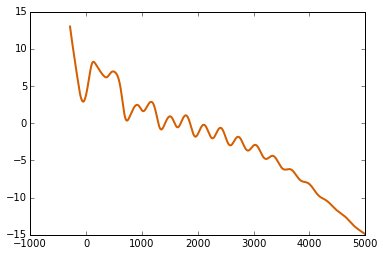

In [373]:
plot(lmap(arange(5001)),(-dCls['cosmo.ommh2']/dCls['cosmo.clamp']),c=clrs[2],lw=2,ls='-')

In [456]:
def mkplot3(dCls,s=1,lsplit=500):
    ax1=gca()
    ax2=ax1.twinx()
    
    # plot(lmap(arange(5001)),(dCls['cosmo.clamp']*dclamp),c=clrs[2],lw=2,ls='-')
    # plot(lmap(arange(5001)),(dCls['cosmo.ns']*dns),c=clrs[2],lw=2,ls='--')

    ax1.plot(lmap(arange(5001)[2:lsplit]),(dCls['cosmo.clamp']*dclamp+dCls['cosmo.ns']*dns)[2:lsplit],c=clrs[2],lw=2,ls='-')
    ax2.plot(lmap(arange(5001)[lsplit:]),(dCls['cosmo.clamp']*dclamp+dCls['cosmo.ns']*dns)[lsplit:],c=clrs[2],lw=2,ls='-')

    # plot(dCls_scalar['cosmo.clamp'],c=clrs[0],ls='--')

    # fac=4.4
    ax1.plot(lmap(arange(5001)[2:lsplit]),s*dCls['cosmo.ommh2'][2:lsplit]*dommh2,c=clrs[1],lw=2)
    ax2.plot(lmap(arange(5001)[lsplit:]),s*dCls['cosmo.ommh2'][lsplit:]*dommh2,c=clrs[1],lw=2)
    # plot(-dCls_scalar['cosmo.ommh2']/fac,c=clrs[1],ls='--')
    ylim(-10,100)
    for ax in [ax1,ax2]: ax.set_xlim(*lmap([1,2509]))
#     legend([r'$dC_\ell/dA_S$','$dC_\ell/dw_m$'])
    # yscale('log')


    ticks=[2,100]+range(500,2500,500)
    ax=ax2
    ax=gca()
    ax.set_xticks(lmap(ticks))
    ax.set_xticks(lmap(range(10,100,10)+range(100,2500,100)),minor=True);

    ax.set_xticklabels(ticks)
    ax1.set_xlabel(r'${\rm multipole \, moment,}\,\ell$',size=18)
    ax1.set_ylabel(r'$\Delta D_\ell\,[\rm \mu K^2]$',size=18)        

    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))    

    ax1.set_ylim(-120,120)
    ax2.set_ylim(-37,37)    
    ax1.plot([lsplit]*2,[-200,200],'k:')
    ax1.plot([lmap(2),2500],[0]*2,'k')
    
    for p in [220,537.5,810.8,1120.9,1444.2,1776,2081,2395]:
        ax.arrow(p, 34, 0, -4, head_width=50, head_length=2, fc='k', ec='k')


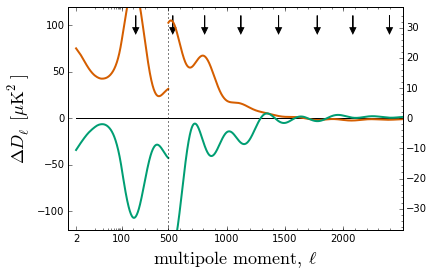

In [461]:
mkplot3(dCls)
savefig('plots/talk/series/dcl.pdf',bbox_inches='tight',transparent=True)

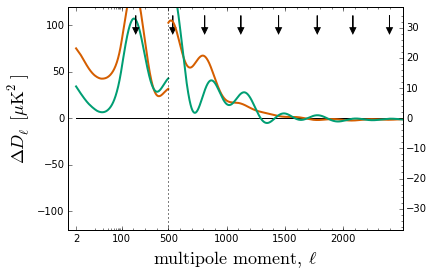

In [462]:
mkplot3(dCls,s=-1)
savefig('plots/talk/series/dcl_flip.pdf',bbox_inches='tight',transparent=True)

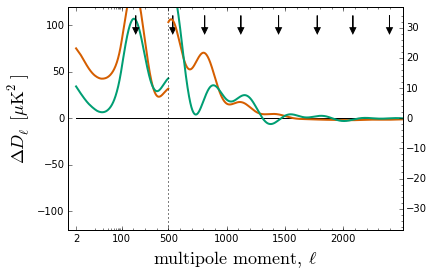

In [463]:
mkplot3(dCls_scalar,s=-1)
savefig('plots/talk/series/dcl_flip_scal.pdf',bbox_inches='tight',transparent=True)

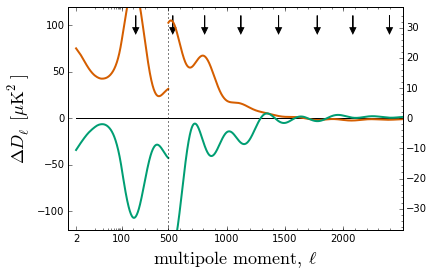

In [464]:
mkplot3(dCls)

# For talk:

In [225]:
mkdir plots/talk/series

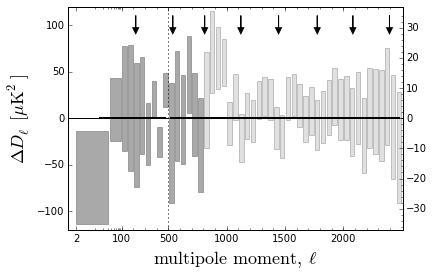

In [236]:
mkpanel((2,800),(2,800),lims,ampns=True,lswitch=500,linsum=False,
        notheta=False,doleg=False,xlbl=True,ylbl=True,arrows=True)
savefig('plots/talk/series/1.pdf',bbox_inches='tight',transparent=True)

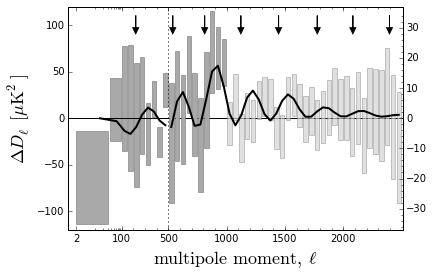

In [237]:
mkpanel((2,1000),(2,800),lims,ampns=True,lswitch=500,linsum=False,docomps=False,
        notheta=False,doleg=False,xlbl=True,ylbl=True,arrows=True)
savefig('plots/talk/series/2.pdf',bbox_inches='tight',transparent=True)

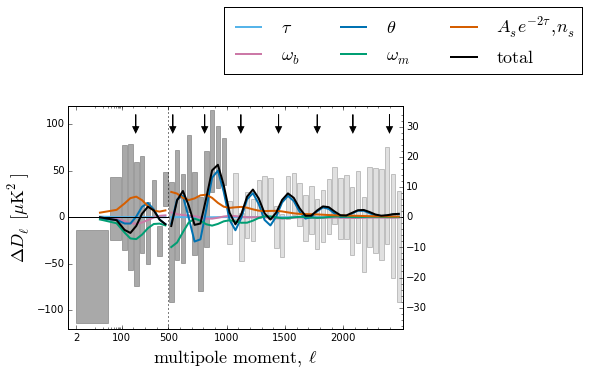

In [500]:
mkpanel((2,1000),(2,800),lims,ampns=True,lswitch=500,linsum=False,docomps=True,
        notheta=False,doleg=True,xlbl=True,ylbl=True,arrows=True,)
savefig('plots/talk/series/leg.pdf',bbox_inches='tight',transparent=True)

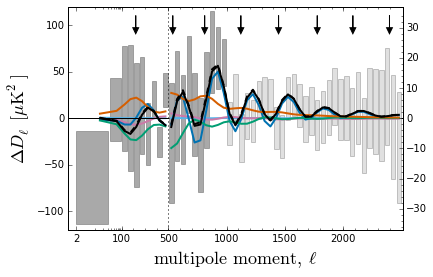

In [251]:
mkpanel((2,1000),(2,800),lims,ampns=True,lswitch=500,linsum=True,docomps=True,
        notheta=False,doleg=False,xlbl=True,ylbl=True,arrows=True)
savefig('plots/talk/series/3_linsum.pdf',bbox_inches='tight',transparent=True)

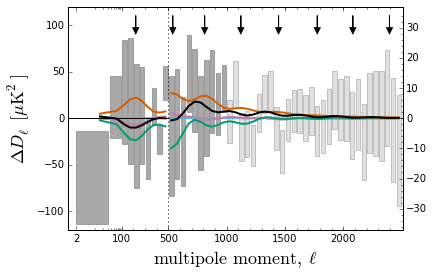

In [242]:
mkpanel((2,1000),(2,800),lims,ampns=True,lswitch=500,linsum=False,docomps=True,
        notheta=True,doleg=False,xlbl=True,ylbl=True,arrows=True)
savefig('plots/talk/series/4.pdf',bbox_inches='tight',transparent=True)

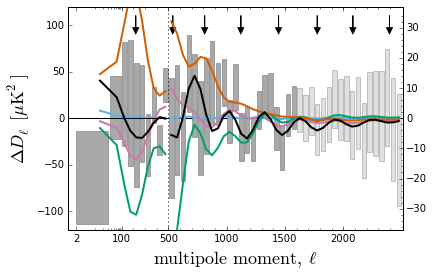

In [465]:
mkpanel((2,1600),(2,800),lims,ampns=True,lswitch=500,linsum=False,
        notheta=True,doleg=False,xlbl=True,ylbl=True,arrows=True)
savefig('plots/talk/series/5.pdf',bbox_inches='tight',transparent=True)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f46fed62b90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46e713d6d0>)

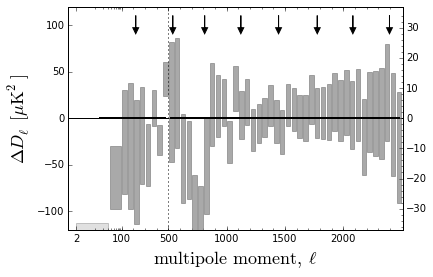

In [478]:
mkpanel((800,2509),(800,2509),lims,ampns=True,lswitch=500,linsum=False,
        notheta=True,doleg=False,xlbl=True,ylbl=True,arrows=True)
# savefig('plots/talk/series/5_fidfull.pdf',bbox_inches='tight',transparent=True)

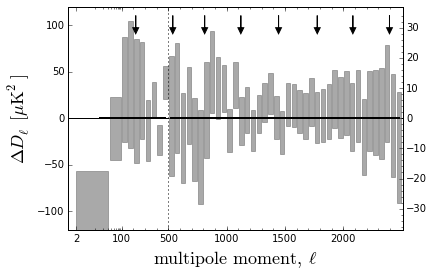

In [502]:
mkpanel((2,2509),(2,2509),lims,ampns=True,lswitch=500,linsum=False,
        notheta=True,doleg=False,xlbl=True,ylbl=True,arrows=True)
savefig('plots/talk/series/last.pdf',bbox_inches='tight',transparent=True)

In [481]:
color_map

[('cosmo.clamp',
  (0.8352941176470589, 0.3686274509803922, 0.0),
  '$A_s e^{-2\\tau}$'),
 ('cosmo.ns', array([ 0.41568627,  0.25490196,  0.18431373]), '$n_s$'),
 ('cosmo.tau',
  (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
  '$\\tau$'),
 ('cosmo.ombh2', (0.8, 0.4745098039215686, 0.6549019607843137), '$\\omega_b$'),
 ('cosmo.theta', (0.0, 0.4470588235294118, 0.6980392156862745), '$\\theta$'),
 ('cosmo.ommh2',
  (0.0, 0.6196078431372549, 0.45098039215686275),
  '$\\omega_m$'),
 ('cosmo.ampns',
  (0.8352941176470589, 0.3686274509803922, 0.0),
  '$A_s e^{-2\\tau},n_s$')]

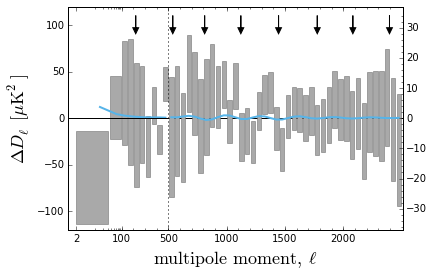

In [492]:
mkpanel((2,2509),(2,800),lims,ampns=True,lswitch=500,linsum=False,
        notheta=True,doleg=False,xlbl=True,ylbl=True,arrows=True,domodel=False,
       color_map=[('cosmo.tau',(0.33725490196078434, 0.7058823529411765, 0.9137254901960784),'$\\tau$')])
savefig('plots/talk/series/7.pdf',bbox_inches='tight',transparent=True)

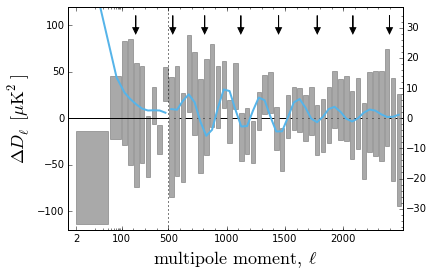

In [491]:
mkpanel((2,2509),(2,800),lims,ampns=True,lswitch=500,linsum=False,
        notheta=True,doleg=False,xlbl=True,ylbl=True,arrows=True,domodel=False,
        fac={'cosmo.tau':10},
       color_map=[('cosmo.tau',(0.33725490196078434, 0.7058823529411765, 0.9137254901960784),'$\\tau$')])
savefig('plots/talk/series/7_bigtau.pdf',bbox_inches='tight',transparent=True)

In [495]:
mkpanel((2,2509),(2,800),lims,ampns=True,lswitch=500,linsum=False,dolegend=True,
        notheta=True,doleg=False,xlbl=True,ylbl=True,arrows=True,domodel=False,
        fac={'cosmo.tau':10},
       color_map=[('cosmo.tau',(0.33725490196078434, 0.7058823529411765, 0.9137254901960784),'$\\tau$')])
savefig('plots/talk/series/7_bigtau.pdf',bbox_inches='tight',transparent=True)

TypeError: mkpanel() got an unexpected keyword argument 'dolegend'

# Filter plots:

In [947]:
lims=array([2,30]+range(100,2500,50)+[2500])
# lims=array([2,30]+range(100,850,50)+[1000,2500])
bin=M.get_bin_func('q',q=M.lims_to_q(zip(lims,lims[1:]-1)))

In [948]:
y=lowl['D_ELL'].mean() - (fid*todl)[2:30].mean(); err=1/sqrt(sum(1/lowl['ERRUP']**2))        

In [974]:
# bin=lambda x:x

name_mapping={
 'cosmo.clamp': 1,
 'cosmo.ns': 1,
 'cosmo.ombh2': 1,
 'cosmo.ommh2': 1,
#  'cosmo.tau': 1,
 'cosmo.theta': 1,
}

fid=r[30,2509]['clTT'][:2509]
lslice=slice(2,800)
bslice=bin(lslice)

m=matrix([bin(dCls[k])[bslice] for k,v in name_mapping.items()])
b=matrix(hstack([y,bin(pkcl-fid*todl)[1:]])[bslice]).T
invs=inv(bmat([[ [[err**2]],     zeros((1,bslice.stop-1))    ],
               [ zeros((bslice.stop-1,1)),  bin(pkcv)[1:bslice.stop,1:bslice.stop] ]])[bslice,bslice])

ip=matrix(diag([1/0.02**2 if 'tau' in k else 0 for k in name_mapping]))
xbar=matrix([0.07 if 'tau' in k else 0 for k in name_mapping]).T

ip=0
w=inv(m*invs*m.T+ip)*m*invs
wghts=dict(zip(name_mapping,w))

shifts = dict(zip(name_mapping,inv(m*invs*m.T+ip)*(m*invs*b+ip*xbar)))

sigs=dict(zip(name_mapping.keys(),sqrt(diag(inv(m*invs*m.T+ip)))))

In [975]:
{k:(r[30,800][k]-r[30,1000][k])/shifts[k] for k in name_mapping}

{'cosmo.clamp': matrix([[ 0.18042659]]),
 'cosmo.ns': matrix([[-0.23093428]]),
 'cosmo.ombh2': matrix([[-0.21150159]]),
 'cosmo.ommh2': matrix([[ 0.07575557]]),
 'cosmo.theta': matrix([[ 1.11056959]])}

In [976]:
zip(name_mapping,(dot(w,b)/sqrt(diag(inv(m*invs*m.T+ip)))).A[0])

[('cosmo.ombh2', 0.9294091830129827),
 ('cosmo.theta', 0.26119789536977417),
 ('cosmo.ns', 0.032360227462694534),
 ('cosmo.clamp', 0.032525375255384681),
 ('cosmo.ommh2', 0.13069214796985648)]

(-360.5170185988091, 2509.0)

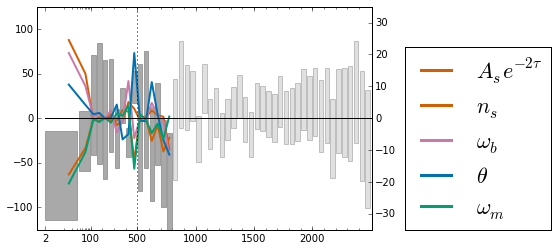

In [979]:
lswitch=500
bsplit=bin(arange(lswitch)).size

ax1=gca()
ax2=ax1.twinx()

for k,c,lbl in color_map:
    if k in wghts:
#         ax1.plot(lmap(bin(arange(2509))[bslice])[:bsplit],(30*wghts[k].A[0]/sigs[k]*b)[:bsplit],c=c,label=lbl,lw=2)
        ax2.plot(lmap(bin(arange(2509))[bslice]),(30*wghts[k].A[0]/sigs[k]*b.A[:,0]),c=c,label=lbl,lw=2)

ax1.fill_between(lmap([2,30]),[y-err]*2,[y+err]*2,facecolor='darkgray',edgecolor='dimgray',lw=0.5)
boxerrs(bin.lmins[1:bsplit],bin.lmaxs[1:bsplit],bin(pkcl-fid*todl)[1:bsplit],sqrt(diag(bin(pkcv)))[1:bsplit], (2,800),ax=ax1)
boxerrs(bin.lmins[bsplit:],bin.lmaxs[bsplit:],bin(pkcl-fid*todl)[bsplit:],sqrt(diag(bin(pkcv)))[bsplit:], (2,800),ax=ax2)
plot(lmap([lswitch]*2),[-100,100],'k:')
plot(lmap([2,2509]),[0]*2,'k')
     
leg=legend(loc=(1.1,0),fontsize=22)
setp(leg.get_lines(),linewidth=3)

ticks=[2,100]+range(500,2500,500)
ax1.set_xticks(lmap(ticks))
ax1.set_xticks(lmap(range(10,100,10)+range(100,2500,100)),minor=True);

ax1.set_ylim(-125,125)
ax2.set_ylim(-35,35)

ax1.set_xticklabels(ticks);
ax1.set_xlim(*lmap([1,2509]))

# savefig('/plots/filter.pdf',bbox_inches='tight')

In [918]:
ps={'cosmo.ombh2', 'cosmo.theta', 'cosmo.ns', 'cosmo.clamp', 'cosmo.ommh2', 'cosmo.tau'}

In [925]:
[(k,
  r[30,800][k] - r[30,2509][k],  
  r[30,800][k] - r[2,800][k],
  r[30,2509][k] - r[2,2509][k],
  (r[30,800][k] - r[30,2509][k]) - (r[30,800][k] - r[2,800][k]) + (r[30,2509][k] - r[2,2509][k]),
  r[2,800][k] - r[2,2509][k])

  
  
  for k in ps]

[('cosmo.ombh2',
  -1.7891967458417979e-05,
  -0.00046413528359700792,
  -3.9760494214537145e-05,
  0.0004064828219240528,
  0.0004064828219240528),
 ('cosmo.ommh2',
  -0.0028023911502047805,
  0.0033328631905078787,
  0.0011130112081828847,
  -0.0050222431325297745,
  -0.0050222431325297745),
 ('cosmo.ns',
  0.000442862158643198,
  -0.016091586186450679,
  -0.0037993739181005903,
  0.012735074426993287,
  0.012735074426993287),
 ('cosmo.tau',
  -0.015229483164390434,
  0.0013743998770894272,
  0.0029934629824217573,
  -0.013610420059058104,
  -0.013610420059058104),
 ('cosmo.theta',
  0.0005984035033672619,
  -0.0008366434168098902,
  -8.434586666949961e-05,
  0.0013507010535076525,
  0.0013507010535076525),
 ('cosmo.clamp',
  -0.01830708174033413,
  0.015638937927601404,
  0.010179848640707423,
  -0.023766171027228111,
  -0.023766171027228111)]